# Improving inter-session EEGNet

In the previous notebooks `6-DL-based-classification.ipynb` it was shown that EEGNet has excellent performance for offline classification of MI EEG data of the same patient on the same session. However, once we considered inter-session data we saw that the non stationarity of the EEG data on different sessions caused issues. This is to be expected as it is a general issue in BCI applications that remains largely unsolved. Before experimenting with the even more challanging inter-subject setting, where a general BCI model is trained to work on an unseen patient, we see if improvements can be made to the inter-session performance of EEGNet through multiple strategies.


## Table of Contents

- Checking requirements
  - Correct anaconda environment
  - Correct module access
  - Correct file access
  - Checking TensorFlow GPU support
- About the data
- Tensorboard
- Fine-tuning EEGNet on few samples
  - Prepping the data
  - Training the model on the train data
  - Testing base model performance on unseen trial
  - Do the fine-tuning

<hr><hr>

## Checking requirements

### Correct anaconda environment

The `bci-master-thesis` anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [1]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
from platform import python_version
from pathlib import Path
from copy import copy

print(f"Active environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Correct environment: {os.environ['CONDA_DEFAULT_ENV'] == 'bci-master-thesis'}")
print(f"\nPython version: {python_version()}")
print(f"Correct Python version: {python_version() == '3.8.10'}")

Active environment: bci-master-thesis
Correct environment: True

Python version: 3.8.10
Correct Python version: True


<hr>

### Correct module access

The following codeblock will load in all required modules and show if the versions match those that are recommended.

In [2]:
####################################################
# LOADING MODULES
####################################################

# allow reloading of libraries
import importlib

# Load utils with reloading allowed
import sys
sys.path.append('../utils')
import CLA_dataset
import TF_tools
importlib.reload(CLA_dataset)
importlib.reload(TF_tools)

# Load EEGModels
import EEGModels
from EEGModels import EEGNet, ShallowConvNet, DeepConvNet

# IO functions
from IPython.utils import io

# Set logging level for MNE before loading MNE
os.environ['MNE_LOGGING_LEVEL'] = 'WARNING'

# Modules tailored for EEG data
import mne; print(f"MNE version (1.0.2 recommended): {mne.__version__}")

import pyriemann as prm; print(f"PyRieMann version (0.2.7 recommended): {prm.__version__}")

# Data manipulation modules
import numpy as np; print(f"Numpy version (1.21.5 recommended): {np.__version__}")
import pandas as pd; print(f"Pandas version (1.4.1 recommended): {pd.__version__}")

# ML libraries
import sklearn;  print(f"Scikit-learn version (1.0.2 recommended): {sklearn.__version__}")
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import OneHotEncoder

# Deep Learning libraries
import tensorflow as tf;  print(f"TensorFlow version (2.8.0 recommended): {tf.__version__}")

import keras; print(f"Keras version (2.8.0 recommended): {keras.__version__}")
from keras.callbacks import ModelCheckpoint

# Storing files
import pickle;  print(f"Pickle version (4.0 recommended): {pickle.format_version}")

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

MNE version (1.0.2 recommended): 1.0.2
PyRieMann version (0.2.7 recommended): 0.2.7
Numpy version (1.21.5 recommended): 1.21.5
Pandas version (1.4.1 recommended): 1.4.1
Scikit-learn version (1.0.2 recommended): 1.0.2
TensorFlow version (2.8.0 recommended): 2.8.0
Keras version (2.8.0 recommended): 2.8.0
Pickle version (4.0 recommended): 4.0
Matplotlib version (3.5.1 recommended): 3.5.1


<hr>

### Correct file access

As mentioned, this experimental notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. FIF files from this same dataset are also made available in [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). A check on the availability of these two datasets is performed below.

In [3]:
####################################################
# CHECKING FILE ACCESS
####################################################

# Use util to determine if we have access
print("Full Matlab CLA file access: " + str(CLA_dataset.check_matlab_files_availability()))
print("Full MNE CLA file access: " + str(CLA_dataset.check_mne_files_availability()))

Full Matlab CLA file access: True
Full MNE CLA file access: True


<hr>

### Checking TensorFlow GPU support

If you want to use TensorFlow with GPU acceleration, the below codeblock can help you gather insight.

In [4]:
TF_tools.check_tf_cpu_gpu_presence()

There are 1 CPUs available under the names:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


There are not GPUs available.


<hr><hr>

## About the data

Remember the meaning of the markers:
- 0: “blank” or nothing is displayed in eGUI
    - Can be seen as a break between stimuli, thus random EEG data that should probably be ignored
- 1: Left hand action
    - EEG data for MI of the left hand
- 2: Right hand action
    - EEG data for MI of the right hand
- 3: Passive/neutral
    - EEG data for MI of neither left nor right hand but 'focused'
- 91: inter-session rest break period
- 92: experiment end
- 99: initial relaxation period

<hr> <hr>

## Tensorboard

To launch the tensorboard use the following command in the `experimental-notebooks` folder:
- Windows: `tensorboard --logdir=./logs/`
- MacOS: `tensorboard --logdir='./logs/'`

<hr><hr>

## Fine-tuning EEGNet on few samples

Since we want to improve the results on a new trial, it is not unreasonable to think that we want to recalibrate the new model.
In it's simplest form, recalibration can be done by taking the previously trained model and training it further on new data from the new trial.
This new data may consists of only a small amount of samples as to not become annoying for the user.
Because we are fine-tuning the model for the new trial rather then completely retraining it, the learning rate is often lowered to combat overfitting to the few samples at hand.
In our case, we consider that we have access to the first 50 samples of the new trial for recalibration as this corresponds roughly to roughly 5 minutes of user input.

In this experiment we compare our approach with the previous obtained results to see if we have improved it.

**Remember the results for subject `C`**

| **Test index** | **Train index** | **Same-session EEGNet** | **Inter-session EEGNet** | **Fine-tuned EEGNet** |
|----------------|-----------------|-------------------------|--------------------------|-----------------------|
| 0              | 1 + 2           | 0.944 / 0.934           | 0.916 / 0.920            | 0.xxx / 0.xxx         |
| 1              | 0 + 2           | 0.931 / 0.913           | 0.852 / 0.860            | 0.xxx / 0.xxx         |
| 2              | 1 + 2           | 0.892 / 0.878           | 0.607 / 0.594            | 0.687 / 0.618         |
| 0              | 1               | 0.944 / 0.934           | 0.891 / 0.860            | 0.xxx / 0.xxx         |
| 1              | 2               | 0.931 / 0.913           | 0.794 / 0.783            | 0.xxx / 0.xxx         |

**For subject `B` these results are**

| **Test index** | **Train index** | **Same-session EEGNet** | **Inter-session EEGNet** | **Fine-tuned EEGNet** |
|----------------|-----------------|-------------------------|--------------------------|-----------------------|
| 0              | 1 + 2           | 0.569 / 0.587           | 0.498 / 0.489            | 0.xxx / 0.xxx         |
| 1              | 0 + 2           | 0.701 / 0.684           | 0.640 / 0.654            | 0.xxx / 0.xxx         |
| 2              | 1 + 2           | 0.816 / 0.792           | 0.677 / 0.660            | 0.xxx / 0.xxx         |

**For subject `E` the results are**

| **Test index** | **Train index** | **Same-session EEGNet** | **Inter-session EEGNet** | **Fine-tuned EEGNet** |
|----------------|-----------------|-------------------------|--------------------------|-----------------------|
| 0              | 1 + 2           | 0.792 / 0.785           | 0.714 / 0.713            | 0.xxx / 0.xxx         |
| 1              | 0 + 2           | 0.795 / 0.799           | 0.667 / 0.646            | 0.xxx / 0.xxx         |
| 2              | 1 + 2           | 0.864 / 0.864           | 0.734 / 0.688            | 0.xxx / 0.xxx         |

Again, we see that the DL approach using EEGNet far outperforms the CSP approach.

### Prepping the data

In [33]:
####################################################
# PREPPING THE DATA
####################################################

# Specify params
test_subject = "C"
test_idx = 0

# Get data and choose test trial
mne_raws = CLA_dataset.get_all_raw_mne_data_for_subject(subject_id= test_subject)
test_trial = mne_raws[test_idx]

# Init variables
epochs = []
labels_train = []

print()

for single_mne_raw in mne_raws:
    # Load epochs from raw
    mne_fixed_window_epochs = CLA_dataset.get_usefull_epochs_from_raw(single_mne_raw, start_offset=-1.5, end_offset=1.5)['task/neutral', 'task/left', 'task/right']
    mne_fixed_window_epochs.reset_drop_log_selection()
    
    if (single_mne_raw == test_trial):
        # Get 30 samples from test set for further calibration
        new_test_samples = np.hstack([mne_fixed_window_epochs['task/neutral'][0:10].selection,
                                      mne_fixed_window_epochs['task/left'][0:10].selection, 
                                      mne_fixed_window_epochs['task/right'][0:10].selection])
        
        mne_fixed_window_epochs_finetune_test_samples = mne_fixed_window_epochs[new_test_samples]
        labels_finetune_test_samples = mne_fixed_window_epochs_finetune_test_samples.events[:, -1]
        
        # Drop the 30 samples from the test set to avoid data leakage
        mne_fixed_window_epochs_test = mne_fixed_window_epochs
        with io.capture_output():
            mne_fixed_window_epochs_test.drop(new_test_samples)
        labels_test = mne_fixed_window_epochs_test.events[:, -1]
        print("Loaded test epochs and extracted labels as well as new finetune test samples")
    else:  
        epochs.append(mne_fixed_window_epochs)
        labels_train.extend(mne_fixed_window_epochs.events[:, -1])
        print("Loaded train epochs and extracted labels")
    
# Make single epoch object for training
with io.capture_output():
    mne_fixed_window_epochs_train = mne.concatenate_epochs(epochs, verbose=False)
print("\n\nConcatenated the train epochs")
print(f"Total amount of train labels: {len(labels_train)}")

# Test epochs are of single trial already
print("\n\nGot the test epochs")
print(f"Total amount of test labels: {len(labels_test)}")

# Go to 2D representation
labels_train = np.array(labels_train).reshape(-1, 1)
labels_test = np.array(labels_test).reshape(-1, 1)
labels_finetune_test_samples = np.array(labels_finetune_test_samples).reshape(-1, 1)

# One Hot Encode the labels
ohe = OneHotEncoder()
ohe_labels_train = ohe.fit_transform(labels_train).toarray()
ohe_labels_test = ohe.transform(labels_test).toarray()
ohe_labels_finetune_test_samples = ohe.transform(labels_finetune_test_samples).toarray()

# Validate OHE
print(f"\nTrain labels OHE match regular labels: {np.array_equal(ohe.inverse_transform(ohe_labels_train), labels_train)}")
print(f"Test labels OHE match regular labels: {np.array_equal(ohe.inverse_transform(ohe_labels_test), labels_test)}")
print(f"Finetune labels OHE match regular labels: {np.array_equal(ohe.inverse_transform(ohe_labels_finetune_test_samples), labels_finetune_test_samples)}")



# Test epochs are of single trial already
print("\n\nGot the finetune test samples epochs")
print(f"Total amount of finetune labels: {len(labels_finetune_test_samples)}")
display(mne_fixed_window_epochs_finetune_test_samples)

# Get training data
with io.capture_output():
    mne_fixed_window_epochs_train_data = mne_fixed_window_epochs_train.get_data(tmin=0.2, tmax=0.7)
    mne_fixed_window_epochs_test_data = mne_fixed_window_epochs_test.get_data(tmin=0.2, tmax=0.7)
    mne_fixed_window_epochs_finetune_test_samples_data = mne_fixed_window_epochs_finetune_test_samples.get_data(tmin=0.2, tmax=0.7)

# Fix scaling sensitivity as MNE stores as data * 10e-6
mne_fixed_window_epochs_train_data = mne_fixed_window_epochs_train_data * 1000000
mne_fixed_window_epochs_test_data = mne_fixed_window_epochs_test_data * 1000000
mne_fixed_window_epochs_finetune_test_samples_data = mne_fixed_window_epochs_finetune_test_samples_data * 1000000

# Remove unused variables
del new_test_samples
del epochs
del mne_fixed_window_epochs
del test_trial
del single_mne_raw
del mne_raws
del mne_fixed_window_epochs_train
del mne_fixed_window_epochs_test
del mne_fixed_window_epochs_finetune_test_samples
del labels_train
del labels_test
del labels_finetune_test_samples
del test_subject
del test_idx

Reading 0 ... 666799  =      0.000 ...  3333.995 secs...
Reading 0 ... 681199  =      0.000 ...  3405.995 secs...
Reading 0 ... 669399  =      0.000 ...  3346.995 secs...

Loaded test epochs and extracted labels as well as new finetune test samples
Loaded train epochs and extracted labels
Loaded train epochs and extracted labels


Concatenated the train epochs
Total amount of train labels: 1919


Got the test epochs
Total amount of test labels: 930

Train labels OHE match regular labels: True
Test labels OHE match regular labels: True
Finetune labels OHE match regular labels: True


Got the finetune test samples epochs
Total amount of finetune labels: 30


Number of events,30
Events,task/left: 10task/neutral: 10task/right: 10
Time range,-1.500 – 2.500 sec
Baseline,0.000 – 1.000 sec


### Training the model on the train data

We start by simply training the model on the available test data.

In [34]:
####################################################
# CREATE EEGNET MODEL
####################################################

# Create the TensorFlow Keras model
keras_eegnet_model = EEGNet(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D' # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    )

# Compile the model so it can be fitted
# Loss and optimizer from EEGNet paper
keras_eegnet_model.compile(loss= 'categorical_crossentropy', 
                           optimizer= tf.keras.optimizers.Adam(learning_rate= 0.001), 
                           metrics= ["accuracy"])

# Show summary of the model
keras_eegnet_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 21, 100, 1)]      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 100, 8)        400       
                                                                 
 batch_normalization_6 (Batc  (None, 21, 100, 8)       32        
 hNormalization)                                                 
                                                                 
 depthwise_conv2d_2 (Depthwi  (None, 1, 100, 16)       336       
 seConv2D)                                                       
                                                                 
 batch_normalization_7 (Batc  (None, 1, 100, 16)       64        
 hNormalization)                                                 
                                                           

In [25]:
####################################################
# TRAIN BASE EEGNET MODEL
####################################################

# Configure
retrain_model = False
tensorboard_name = "EEGNet_multisession_C0-C1-train_100hz"
best_base_model_filename = f"./saved_variables/7/Base-EEGNet/{tensorboard_name}"


# Train on train/test split of data from one session
## Note: the model is forced to use GPU, if GPU is not available replace with what is available e.g. /cpu:0
## TODO: Change to CPU/GPU preference
if (retrain_model): # Retrain or not
    with tf.device('/gpu:0'):
        keras_eegnet_model.fit(
            x= mne_fixed_window_epochs_train_data,
            y= ohe_labels_train,
            batch_size= 128, # Default: 32
            epochs= 500, # Default: 500 (EEGNet paper)
            verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
            callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                        TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                        TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
            validation_split= 0.3,
            shuffle= True,
            sample_weight= None, # Can be interesting due to time series
            use_multiprocessing=True, # Done for faster speed
            workers= 4 # Done for faster speed
            )

# Delete unused variables
del retrain_model
del tensorboard_name

### Testing base model performance on unseen trial

Results for lowest loss model on unseen trial without optimisations
Accuracy of: 0.6167922497308934


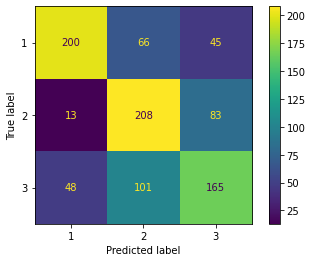



Results for highest accuracy model on unseen trial without optimisations
Accuracy of: 0.6210979547900969


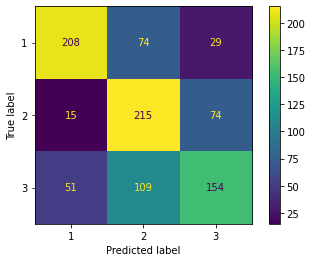

In [26]:
####################################################
# BASE EEGNET MODEL PERFORMANCE
####################################################

# Convert labels back to original
y_test = ohe.inverse_transform(ohe_labels_test)

# Get results for best validation loss model
print("Results for lowest loss model on unseen trial without optimisations")
keras_eegnet_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)

y_pred = keras_eegnet_model.predict(mne_fixed_window_epochs_test_data)
y_pred = ohe.inverse_transform(y_pred)

accuracy =  accuracy_score(y_test, y_pred)

print(f"Accuracy of: {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
plt.show()

# Get results for best validation loss model
print("\n\nResults for highest accuracy model on unseen trial without optimisations")
keras_eegnet_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)

y_pred = keras_eegnet_model.predict(mne_fixed_window_epochs_test_data)
y_pred = ohe.inverse_transform(y_pred)

accuracy =  accuracy_score(y_test, y_pred)

print(f"Accuracy of: {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
plt.show()

# Remove unused variables
del accuracy
del y_pred
del y_test
del keras_eegnet_model

### Do the fine-tuning


In [29]:
####################################################
# FINE-TUNE BASE EEGNET MODEL ON NEW TRIAL SAMPLES
####################################################

# Configure
retrain_model = False
tensorboard_name = "EEGNet_multisession_C0-C1-train_C2-test-samples-finetune_100hz"
best_finetune_model_filename = f"./saved_variables/7/finetune-EEGNet/{tensorboard_name}"

# Get previously trained model
keras_eegnet_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)

# Unfreeze the base model
keras_eegnet_model.trainable = True

# Recompile base model
keras_eegnet_model.compile(loss= 'categorical_crossentropy', 
                           optimizer= tf.keras.optimizers.Adam(learning_rate= 0.0001), 
                           metrics= ["accuracy"])

# Retrain the base model
## Note: the model is forced to use GPU, if GPU is not available replace with what is available e.g. /cpu:0
## TODO: Change to CPU/GPU preference
if (retrain_model): # Retrain or not
    with tf.device('/cpu:0'):
        keras_eegnet_model.fit(
            x= mne_fixed_window_epochs_finetune_test_samples_data,
            y= ohe_labels_finetune_test_samples,
            batch_size= 16, # Default: 32 - 16 since we only have 30 samples
            epochs= 500, # Default: 500 (EEGNet paper) - concur overfit
            verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
            callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                        TF_tools.lowest_loss_model_save_callback(filepath= best_finetune_model_filename),
                        TF_tools.highest_accuracy_model_save_callback(filepath= best_finetune_model_filename)],
            validation_split= 0.2,
            shuffle= True,
            sample_weight= None, # Can be interesting due to time series
            use_multiprocessing=True, # Done for faster speed
            workers= 4 # Done for faster speed
            )
        
# Delete unused variables
del retrain_model
del tensorboard_name
del keras_eegnet_model

Epoch 1/500
1/2 [==============>...............] - ETA: 0s - loss: 1.1991 - accuracy: 0.5625
Epoch 1: val_loss improved from inf to 0.83803, saving model to ./saved_variables/7/finetune-EEGNet/EEGNet_multisession_C0-C1-train_C2-test-samples-finetune_100hz_lowest_loss_model.hdf5

Epoch 1: val_accuracy improved from -inf to 0.66667, saving model to ./saved_variables/7/finetune-EEGNet/EEGNet_multisession_C0-C1-train_C2-test-samples-finetune_100hz_highest_acc_model.hdf5
2/2 [==============================] - 1s 229ms/step - loss: 1.2415 - accuracy: 0.5417 - val_loss: 0.8380 - val_accuracy: 0.6667
Epoch 2/500
1/2 [==============>...............] - ETA: 0s - loss: 1.0487 - accuracy: 0.5000
Epoch 2: val_loss improved from 0.83803 to 0.83117, saving model to ./saved_variables/7/finetune-EEGNet/EEGNet_multisession_C0-C1-train_C2-test-samples-finetune_100hz_lowest_loss_model.hdf5

Epoch 2: val_accuracy did not improve from 0.66667
2/2 [==============================] - 0s 77ms/step - loss: 0.941

Results for lowest loss model on unseen trial with finetuning
Accuracy of: 0.6867599569429494


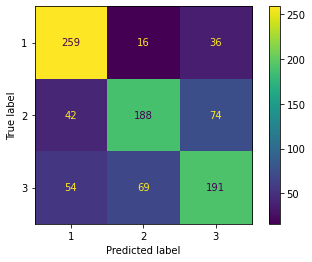



Results for highest accuracy model on unseen trial with finetuning
Accuracy of: 0.6178686759956943


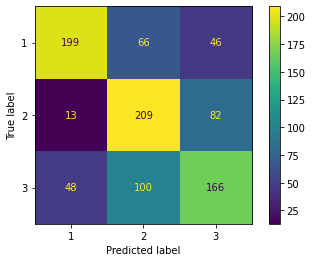

In [32]:
####################################################
# FINETUNED EEGNET MODEL PERFORMANCE
####################################################

# Convert labels back to original
y_test = ohe.inverse_transform(ohe_labels_test)

# Get results for best validation loss model
print("Results for lowest loss model on unseen trial with finetuning")
keras_eegnet_model = TF_tools.load_lowest_loss_model(filepath= best_finetune_model_filename)

y_pred = keras_eegnet_model.predict(mne_fixed_window_epochs_test_data)
y_pred = ohe.inverse_transform(y_pred)

accuracy =  accuracy_score(y_test, y_pred)

print(f"Accuracy of: {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
plt.show()

# Get results for best validation loss model
print("\n\nResults for highest accuracy model on unseen trial with finetuning")
keras_eegnet_model = TF_tools.load_highest_accuracy_model(filepath= best_finetune_model_filename)

y_pred = keras_eegnet_model.predict(mne_fixed_window_epochs_test_data)
y_pred = ohe.inverse_transform(y_pred)

accuracy =  accuracy_score(y_test, y_pred)

print(f"Accuracy of: {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
plt.show()

# Remove unused variables
del accuracy
del y_pred
del y_test
del keras_eegnet_model

In [ ]:
####################################################
# CLEAUP
####################################################

# delete unused variables
del best_model_filename
del keras_eegnet_model

del mne_fixed_window_epochs_test_data
del mne_fixed_window_epochs_train_data
del mne_fixed_window_epochs_finetune_test_samples

del ohe

del ohe_labels_finetune_test_samples
del ohe_labels_test
del ohe_labels_train